This notebook generates the figures for Chapter 4: Spatial Normalization from Poldrack, Mumford, and Nichols' _Handbook of fMRI Data Analysis (2nd Edition)_

In [2]:
import os,sys
from wand.image import Image as WImage
import numpy
import scipy.stats
import matplotlib.pyplot as plt
import nilearn.plotting
%matplotlib inline
import nibabel
from nipype.interfaces import fsl

from nipype.caching import Memory
# use nipype's caching mechanism to save the results of the processing
mem = Memory(base_dir='.')

# set up rpy2 so we can use R magic
%load_ext rpy2.ipython

from fmrihandbook.utils.config import Config

config=Config()



using base dir: /Users/poldrack/data/fmri-handbook-2e-data


__Figure 4.1__: Use original manually generated version

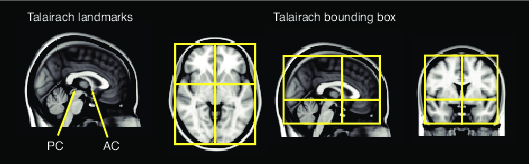

In [3]:
WImage(filename=os.path.join(config.orig_figuredir,'Figure_4_1.pdf'))

__Figure 4.2__: Bias field correction

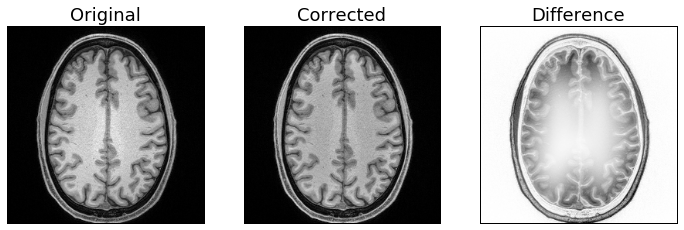

In [5]:
fig=plt.figure(figsize=(12,6))
orig=nibabel.load(config.data['T1'])
origdata=orig.get_data()
bc=nibabel.load(config.data['T1_bc'])
bc_data=bc.get_data()
diff=origdata - bc_data
diffimg=nibabel.Nifti1Image(diff,orig.get_affine(),orig.get_header())

cut_coord=180
ax1 = plt.subplot2grid((1,3), (0,0))
plt.xticks([])
plt.yticks([])
plt.title('Original',fontsize=18)
#nilearn.plotting.plot_anat(orig,display_mode='z',axes=ax1,
#                        cut_coords=[40],annotate=False)
ax1.imshow(numpy.rot90(origdata[:,:,cut_coord]),cmap='gray')
ax2 = plt.subplot2grid((1,3), (0,1))
ax2.imshow(numpy.rot90(bc_data[:,:,cut_coord]),cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Corrected',fontsize=18)
#nilearn.plotting.plot_anat(bc,display_mode='z',axes=ax2,
#                        cut_coords=[40],annotate=False)

ax3 = plt.subplot2grid((1,3), (0,2))
p=ax3.imshow(numpy.rot90(diff[:,:,cut_coord]),cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Difference',fontsize=18)
#nilearn.plotting.plot_anat(diffimg,display_mode='z',axes=ax3,
#                        cut_coords=[40],annotate=False)

__Figure 4.3__: Use original manually generated version

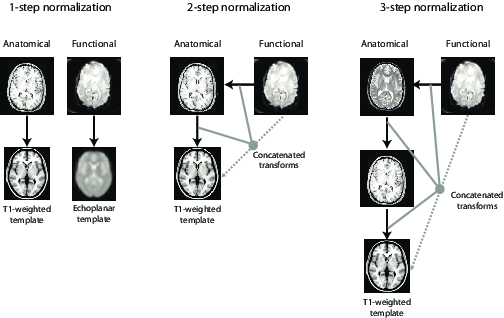

In [6]:
WImage(filename=os.path.join(config.orig_figuredir,'Figure_4_3.pdf'))

__Figure 4.4__: Examples from different normalization procedures

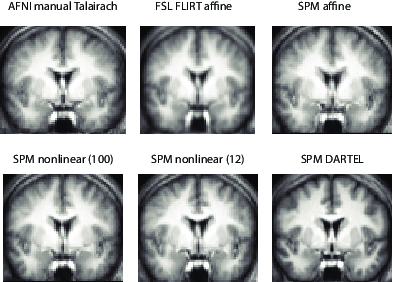

In [7]:
WImage(filename=os.path.join(config.orig_figuredir,'Figure_4_4.pdf'))

__Figure 4.5__: Warp fields

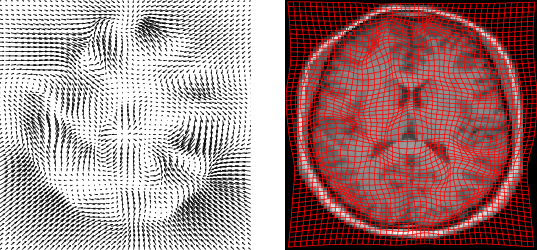

In [8]:
WImage(filename=os.path.join(config.orig_figuredir,'Figure_4_5.pdf'))

__Figure 4.6__: Examples of cortical surfaces.  Perhaps think about replacing with connectome workbench examples?

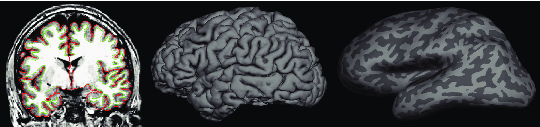

In [9]:
WImage(filename=os.path.join(config.orig_figuredir,'Figure_4_6.pdf'))

__Figure 4.7__: Activation maps obtained using linear and nonlinear methods. __Replace with ANTs example__

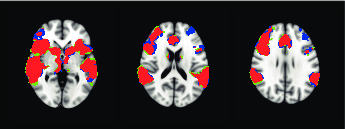

In [10]:
WImage(filename=os.path.join(config.orig_figuredir,'Figure_4_7.pdf'))

__Figure 4.8__: QA for normalization.  __Perhaps a better example using newer registration methods?__

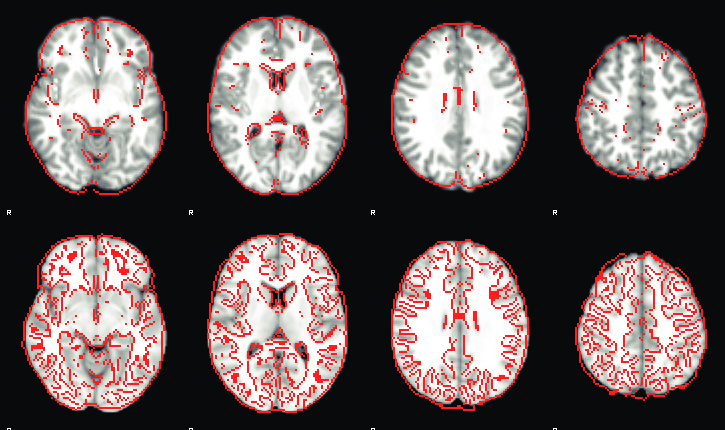

In [11]:
WImage(filename=os.path.join(config.orig_figuredir,'Figure_4_8.pdf'))

__Figure 4.9__: Example of failed registration due to lack of brain extraction

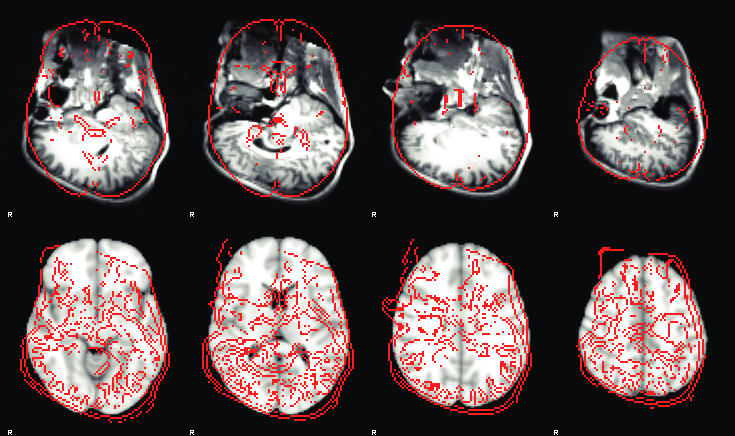

In [12]:
WImage(filename=os.path.join(config.orig_figuredir,'Figure_4_9.pdf'))

__Figure 4.10__: Use original manual example

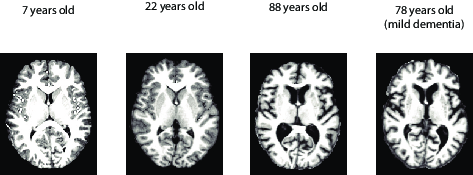

In [13]:
WImage(filename=os.path.join(config.orig_figuredir,'Figure_4_10.pdf'))

__Figure 4.11__: Registration of lesioned brain using cost function masking

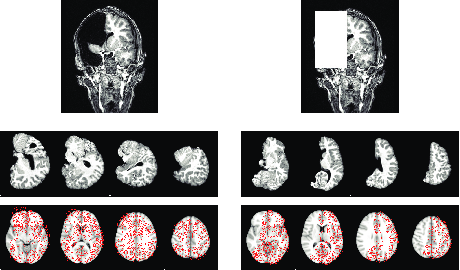

In [14]:
WImage(filename=os.path.join(config.orig_figuredir,'Figure_4_11.pdf'))